## Midterm Project: Predicting Arrival Delay for Airlines
    by Elie Saliba and Kevin Ting

### Task: 

Build a ML model to predict delays on flights (**ARR_DELAY**) from first 7 days of 2020.

### Approach: 
    1) Load data
    2) Wrangle data: Check for sparse features to remove them
    3) Wrangle data: Remove columns that will not be available for evaluation
    4) Wrangle data: Check for columns with a few missing values to impute with zero, mean or median
    5) Wrangle data: Encode categorical values to numerical values
    6) Exploratory analyss: Visualize data distribution with histograms
    7) Exploratory analyss: Use measures of central tendency and IQR to understand data at various positions
    
    8) Variable interdependence: Infer multicollinearity of data through correlation matrix
    9) Feature selection: Remove redundant variables (i.e. columns that refer to the same thing e.g. ID)
    10) Feature engineering: Remove highly collinear variables (i.e. correlation > 0.8)
    11) Feature engineering: Reduce data dimension to the variables that most explain variation in target variable
    12) Modeling building: Random forest is chosen for machine learning modeling
    13) Model comparison: Random forest modeling with original raw data (PART 2) and PCA transformed data (PART 3)
    14) Machine learning process:
        (a) Train/test data: Split data for training and testing
        (b) Model creation: Create models in a grid search for a combination of parameters
        (c) Model selection: Use 10-fold cross validation to evaluate model performance and select the best one
        (c) Final Model training: Use parameters of the best model from above to train on entire train set
        (d) Final Model evaluation: Use 10-fold cross validation for average error on 10 folds of training data
        (e) Final Model performance evaluation: Use confusion matrix, Precision, Recall, ROC to evaluate performance

### Environment Setup

In [22]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

### 1. Load Data

In [2]:
startTime = datetime.datetime.now()
df = pd.read_csv("data/airline_sample_150k.csv")
df.head(2)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-01-01,AA,AA_CODESHARE,AA,5241,OH,N703PS,5241,11057,CLT,...,562,25.0,0.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2019-01-01,NK,NK,NK,115,NK,N525NK,115,10821,BWI,...,1491,0.0,0.0,15.0,0.0,0.0,NaN,NaN,NaN,NaN


### 2. Wrangle data

In [3]:
print(f'Dimension: {len(df.columns)}')
print(f'Sparsity per variable:\n{(len(df.index) - df.count()) / len(df.index) * 100}')

Dimension: 42
Sparsity per variable:
fl_date                  0.000000
mkt_unique_carrier       0.000000
branded_code_share       0.000000
mkt_carrier              0.000000
mkt_carrier_fl_num       0.000000
op_unique_carrier        0.000000
tail_num                 0.302857
op_carrier_fl_num        0.000000
origin_airport_id        0.000000
origin                   0.000000
origin_city_name         0.000000
dest_airport_id          0.000000
dest                     0.000000
dest_city_name           0.000000
crs_dep_time             0.000000
dep_time                 1.595507
dep_delay                1.623211
taxi_out                 1.681138
wheels_off               1.681138
wheels_on                1.739694
taxi_in                  1.739694
crs_arr_time             0.000000
arr_time                 1.701916
arr_delay                1.929216
cancelled                0.000000
cancellation_code       98.344677
diverted                 0.000000
dup                      0.000000
crs_elapsed

In [4]:
df.describe()

,mkt_carrier_fl_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
count,158821.000000,158821.000000,158821.000000,158821.000000,158821.000000,156287.000000,156243.000000,156151.000000,156151.000000,156058.000000,...,158821.000000,29871.000000,29871.000000,29871.00000,29871.000000,29871.000000,1056.000000,1056.000000,1056.000000,0.0
mean,2731.550922,2731.520435,12676.521115,12684.492076,1330.071294,1334.219654,10.678347,17.514707,1358.303623,1459.832485,...,768.048816,20.236115,3.766663,16.34110,0.062603,28.061866,1349.138258,37.618371,36.997159,NaN
std,1861.710239,1861.786465,1523.258647,1522.042773,489.098651,502.999576,48.842558,10.052736,504.539066,531.746813,...,585.328421,63.790109,31.296086,39.87713,1.749522,54.505342,495.648285,33.418773,32.638897,NaN
min,1.000000,1.000000,10135.000000,10135.000000,2.000000,1.000000,-62.000000,0.000000,1.000000,1.000000,...,31.000000,0.000000,0.000000,0.00000,0.000000,0.000000,6.000000,1.000000,1.000000,NaN
25%,1127.000000,1127.000000,11292.000000,11292.000000,916.000000,919.000000,-6.000000,11.000000,934.000000,1045.000000,...,341.000000,0.000000,0.000000,0.00000,0.000000,0.000000,915.500000,16.000000,16.000000,NaN
50%,2311.000000,2311.000000,12889.000000,12889.000000,1321.000000,1327.000000,-2.000000,15.000000,1340.000000,1500.000000,...,604.000000,0.000000,0.000000,3.00000,0.000000,4.000000,1408.500000,27.000000,27.000000,NaN
75%,4321.000000,4321.000000,14057.000000,14057.000000,1735.000000,1743.000000,7.000000,20.000000,1759.000000,1908.000000,...,1005.000000,17.000000,0.000000,20.00000,0.000000,34.000000,1743.250000,47.000000,45.000000,NaN
max,9391.000000,9391.000000,16869.000000,16869.000000,2359.000000,2400.000000,1433.000000,175.000000,2400.000000,2400.000000,...,5095.000000,1433.000000,1203.000000,1218.00000,140.000000,1050.000000,2347.000000,225.000000,211.000000,NaN


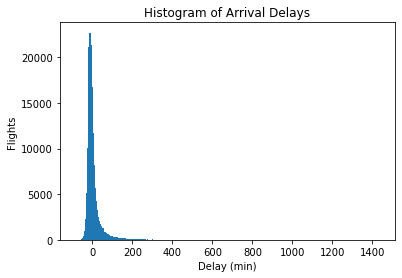

In [5]:
plt.hist(df['arr_delay'], bins=300)
plt.title('Histogram of Arrival Delays')
plt.xlabel('Delay (min)')
plt.ylabel('Flights')
plt.show()

In [6]:
# remove outlier from ARR_DELAY
df['arr_delay'] = df['arr_delay'].apply(lambda x: x if x < 300 else np.nan)
df['arr_delay'] = df['arr_delay'].apply(lambda x: x if x > -100 else np.nan)

In [7]:
# drop features that have >80% sparsity
df = df.iloc[:, :-9]
df = df.drop('cancellation_code', axis=1)

# drop features that won't be available for evaluation
df = df.drop([
    'dep_time', 'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 
    'arr_time', 'cancelled', 'diverted', 'actual_elapsed_time','air_time'], 
    axis=1
)

# drop ARR_DELAY rows with NaN
df = df.drop(df[df['arr_delay'].isna()].index).reset_index(drop=True)

print(f'Dimension reduces to: {len(df.columns)}')

Dimension reduces to: 21


In [8]:
# converting FL_DATE to datetime type for easy wrangling
df['fl_date'] = pd.to_datetime(df['fl_date'], format='%Y-%m-%d')

# creating MONTH from FL_DATE
months = [df['fl_date'][i].month for i in range(len(df['fl_date']))]
df.insert(1, 'month', value=months)

# creating WEEKDAY from FL_DATE
weekdays = [df['fl_date'][i].weekday() for i in range(len(df['fl_date']))]
df.insert(2, 'weekday', value=weekdays)

print(f'Dimension increase to: {len(df.columns)}')

Dimension increase to: 23


In [9]:
df.columns

Index(['fl_date', 'month', 'weekday', 'mkt_unique_carrier',
       'branded_code_share', 'mkt_carrier', 'mkt_carrier_fl_num',
       'op_unique_carrier', 'tail_num', 'op_carrier_fl_num',
       'origin_airport_id', 'origin', 'origin_city_name', 'dest_airport_id',
       'dest', 'dest_city_name', 'crs_dep_time', 'crs_arr_time', 'arr_delay',
       'dup', 'crs_elapsed_time', 'flights', 'distance'],
      dtype='object')

In [10]:
# encoding categorical features with LabelEncoder
le = LabelEncoder()

df['mkt_unique_carrier'] = le.fit_transform(df['mkt_unique_carrier'])
mktUniqueCarrier = list(le.classes_)
df['branded_code_share'] = le.fit_transform(df['branded_code_share'])
brandedCodeShare = list(le.classes_)
df['mkt_carrier'] = le.fit_transform(df['mkt_carrier'])
mktCarrier = list(le.classes_)
df['mkt_carrier_fl_num'] = le.fit_transform(df['mkt_carrier_fl_num'])
mktCarrierFlNum = list(le.classes_)
df['op_unique_carrier'] = le.fit_transform(df['op_unique_carrier'])
opUniqueCarrier = list(le.classes_)
df['tail_num'] = le.fit_transform(df['tail_num'])
tailNum = list(le.classes_)
df['op_carrier_fl_num'] = le.fit_transform(df['op_carrier_fl_num'])
opCarrierFlNum = list(le.classes_)

df['origin_airport_id'] = le.fit_transform(df['origin_airport_id'])
originAirportId = list(le.classes_)
df['origin'] = le.fit_transform(df['origin'])
origin = list(le.classes_)
df['origin_city_name'] = le.fit_transform(df['origin_city_name'])
originCityName = list(le.classes_)

df['dest_airport_id'] = le.fit_transform(df['dest_airport_id'])
destAirportId = list(le.classes_)
df['dest'] = le.fit_transform(df['dest'])
dest = list(le.classes_)
df['dest_city_name'] = le.fit_transform(df['dest_city_name'])
destCityName = list(le.classes_)
df['dup'] = le.fit_transform(df['dup'])
dup = list(le.classes_)

### Exploratory Analysis

<Figure size 1080x360 with 0 Axes>

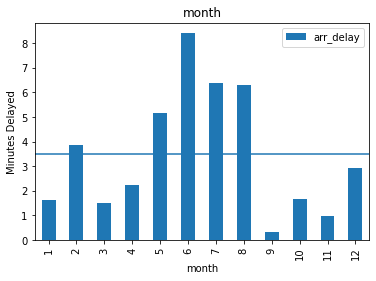

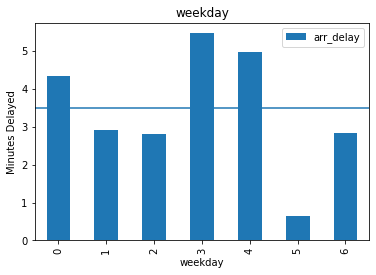

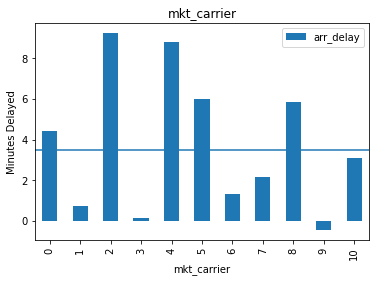

In [11]:
# average delay of flights per catergory compare to overall delay from all records
avg_delay = df.arr_delay.mean()
categories = ['month', 'weekday', 'mkt_carrier']

for i, pred in enumerate(categories):
    plt.figure(i, figsize=(15, 5))
    group = df.groupby(pred, as_index=False).mean()[[pred, 'arr_delay']]
    group.sort_values(by=pred, inplace=True)
    group.plot.bar(x=pred, y='arr_delay')
    plt.axhline(y=avg_delay)
    plt.ylabel('Minutes Delayed')
    plt.title(pred)

# transform categorical features into dummies
cols_dummies = pd.get_dummies(df['mkt_carrier'])

# extract numerical features
cols_num = df[['month', 'weekday', 'distance', 'arr_delay']]

# combine numerical and categorical (dummies) features into final dataframe
df = pd.concat([cols_num, cols_dummies], axis=1)

print(f'Final Dimension: {len(df.columns)}')

### Make Training and Testing Group

In [12]:
X = df.drop(['fl_date', 'arr_delay'], axis=1)
y = df['arr_delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Random Forest

Mean Absolute Error: 21.613060122043535
Mean Square Error: 1271.7141328116184
Root Mean Square Error: 4.648984848549577
R2 Error: 0.02422732566029473


Text(0, 0.5, 'Prediction')

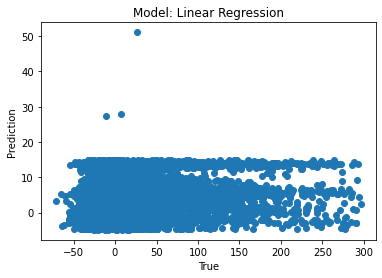

In [24]:
startTimeRF = datetime.datetime.now()

model_to_fit = RandomForestRegressor(n_estimators=100, max_depth=4)

model = model_to_fit.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'Mean Square Error: {metrics.mean_squared_error(y_test, y_pred)}')
print(f'Root Mean Square Error: {np.sqrt(metrics.mean_absolute_error(y_test, y_pred))}')
print(f'R2 Error: {metrics.r2_score(y_test, y_pred)}')


plt.scatter(x=y_test, y=y_pred)
plt.title('Model: Linear Regression')
plt.xlabel('True')
plt.ylabel('Prediction')

print(f'RandomForest run time: [{datetime.datetime.now() - startTimeRF}].')

In [29]:
print(f'RF Score: {model.score(X_train, y_train)}')

RF Score: 0.026092357421197976


In [19]:
print(f'Total run time: [{datetime.datetime.now() - startTime}].')

Total run time: [0:03:33.192200].
